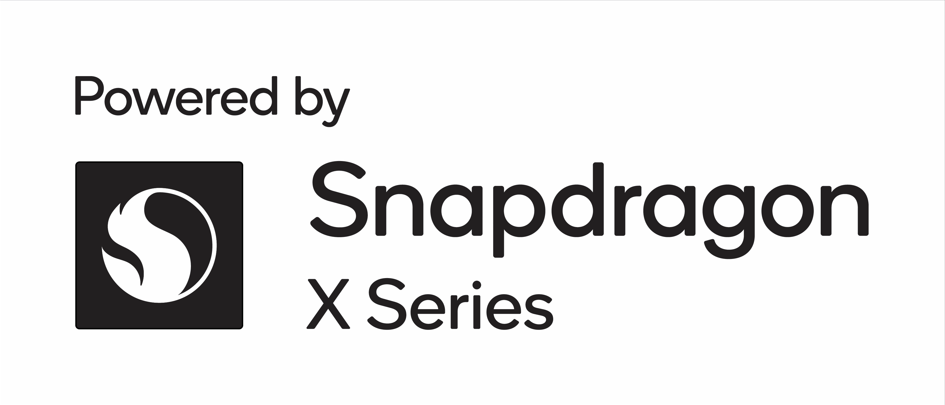

In [1]:
import platform

arch = platform.machine()
sys = platform.system()
processor = platform.processor()
print(f"{arch}\n{sys}\n{processor}")

ARM64
Windows
ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc


In [2]:
import onnxruntime as ort
import os
import numpy as np
import time
import gc
import psutil

from pathlib import Path
from tokenizers import Tokenizer

In [3]:
root_dir = Path.cwd().parent.parent
onnx_root = Path(ort.__file__).parent

In [4]:
# Subdirectory where all .onnx dependencies are located
model_subdirectory = "qnn-deepseek-r1-distill-qwen-7b"

# The embeddings model is entry point, use netron to visualize
model_name = "deepseek_r1_7b_embeddings_quant_v1.0.onnx"

# This graph is used to process initial prompt, we can pass up to 64 tokens
context_model = "deepseek_r1_7b_ctx_v1.0.onnx_ctx.onnx"

# This graph is used to perform next word inference after the initial prompt
context_model_iter = "deepseek_r1_7b_iter_v1.0.onnx_ctx.onnx"

# This graph allows us to take hidden states and return logits
head_model = "deepseek_r1_7b_head_quant_v1.0.onnx"

# Tokenizer
tokenizer_json = "tokenizer.json"

In [5]:
model_path = root_dir/"models"/model_subdirectory/model_name
ctx_path = root_dir/"models"/model_subdirectory/context_model
ctx_path_itr = root_dir/"models"/model_subdirectory/context_model_iter
head_path = root_dir/"models"/model_subdirectory/head_model
tokenizer_path = root_dir/"models"/model_subdirectory/tokenizer_json
hexagon_driver = onnx_root/"capi"/"QnnHtp.dll"

In [6]:
model_path

WindowsPath('C:/Users/DFS/Desktop/gitrepo/qnn_sample_apps/models/qnn-deepseek-r1-distill-qwen-7b/deepseek_r1_7b_embeddings_quant_v1.0.onnx')

In [7]:
hexagon_driver

WindowsPath('C:/Users/DFS/Desktop/gitrepo/env_arm64/Lib/site-packages/onnxruntime/capi/QnnHtp.dll')

In [8]:
model_path.is_file()

True

In [9]:
hexagon_driver.is_file()

True

In [10]:
session_options = ort.SessionOptions()

qnn_provider_options = {
    # Path to the backend driver "Hexagon"
    "backend_path": hexagon_driver,
    # https://onnxruntime.ai/docs/execution-providers/QNN-ExecutionProvider.html#configuration-options
    "htp_performance_mode": "burst",
    "soc_model": "60",
    # "enable_htp_context_cache": "0",
    # "profiling_level": "detailed",
    # "profiling_file_path": root_dir/"models"/model_subdirectory/"profiling_deepseek_7b.csv",
    # Enabling graph optimization causes problems, need to look into this
    "htp_graph_finalization_optimization_mode": "3",
    "qnn_context_priority":"high",
}

# Creating an inference session for the embedding graph
embedding_session = ort.InferenceSession(model_path,
                                providers= [("QNNExecutionProvider",qnn_provider_options)],
                               sess_options= session_options
                              )

# Creating an inference session for the single prediction context graph (iter_ctx)
ctx_itr_session = ort.InferenceSession(ctx_path_itr,
                                         providers=[("QNNExecutionProvider",qnn_provider_options)],
                                         sess_options= session_options
                                      )

# Creating an inference session for the initial context graph
ctx_session = ort.InferenceSession(ctx_path,
                                    providers=[("QNNExecutionProvider",qnn_provider_options)],
                                    sess_options= session_options
                                        )

# Creating an inference session for the head session which will provide logits from hidden states
head_session = ort.InferenceSession(head_path,
                                providers= [("QNNExecutionProvider",qnn_provider_options)],
                               sess_options= session_options
                              )

embedding_session.get_providers()

['QNNExecutionProvider', 'CPUExecutionProvider']

In [11]:
# Load in tokenizer using tokenizer path above
tokenizer = Tokenizer.from_file(str(tokenizer_path))

In [12]:
query = "<｜User｜>\nImagine you are a cyber security professional. Provide step by step reasons why AI models should be ran locally. Please consider all aspects of data privacy and cyber security\n<｜Assistant｜><think>\n"
query

'<｜User｜>\nImagine you are a cyber security professional. Provide step by step reasons why AI models should be ran locally. Please consider all aspects of data privacy and cyber security\n<｜Assistant｜><think>\n'

In [13]:
encoding = tokenizer.encode(query)
encoding

Encoding(num_tokens=38, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [20]:
encoding.tokens

['<｜begin▁of▁sentence｜>',
 '<｜User｜>',
 'Ċ',
 'Imagine',
 'Ġyou',
 'Ġare',
 'Ġa',
 'Ġcyber',
 'Ġsecurity',
 'Ġprofessional',
 '.',
 'ĠProvide',
 'Ġstep',
 'Ġby',
 'Ġstep',
 'Ġreasons',
 'Ġwhy',
 'ĠAI',
 'Ġmodels',
 'Ġshould',
 'Ġbe',
 'Ġran',
 'Ġlocally',
 '.',
 'ĠPlease',
 'Ġconsider',
 'Ġall',
 'Ġaspects',
 'Ġof',
 'Ġdata',
 'Ġprivacy',
 'Ġand',
 'Ġcyber',
 'Ġsecurity',
 'Ċ',
 '<｜Assistant｜>',
 '<think>',
 'Ċ']

In [21]:
input_ids = encoding.ids
input_ids

[151646,
 151644,
 198,
 51057,
 498,
 525,
 264,
 20847,
 4763,
 6584,
 13,
 39565,
 3019,
 553,
 3019,
 7966,
 3170,
 15235,
 4119,
 1265,
 387,
 10613,
 23490,
 13,
 5209,
 2908,
 678,
 13566,
 315,
 821,
 12345,
 323,
 20847,
 4763,
 198,
 151645,
 151648,
 198]

In [22]:
for layer in embedding_session.get_inputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: input_ids
Shape: [1, 'seq_len']
Type: tensor(int64)


In [23]:
input_ids = np.array([input_ids], dtype=np.int64)
input_ids.shape

(1, 38)

In [24]:
embedding_output = embedding_session.run(None, {"input_ids": input_ids})[0]
print("(batch, sequence length, embedding dimension)")
embedding_output.shape

(batch, sequence length, embedding dimension)


(1, 38, 3584)

In [25]:
for layer in embedding_session.get_outputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: input_hidden_states
Shape: [1, 'seq_len', 3584]
Type: tensor(float)


In [26]:
# Number of input sequences processed simultaneously
batch_size = 1

# Current sequence length for initial prompt (number of tokens in current sequence)
seq_len = embedding_output.shape[1]

# Dimensionality of each token embedding vector
hidden_size = embedding_output.shape[2]

# Number of attention heads in each transformer layer
num_heads = 28

# Size of each attention head (should be hidden_size // num_heads
attn_head_size = 128 

# Total number of transformer layers
num_layers = 28

# SWA
max_seq_len = 64

# Number of key/value heads (key/value heads are shared amongst attention heads)
num_key_value_heads = 4

In [31]:
for layers in ctx_session.get_inputs():
    print(f"Name: {layers.name}")
    print(f"Shape: {layers.shape}")
    print(f"Type: {layers.type}")

Name: past_keys_0
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_0
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_1
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_1
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_2
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_2
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_3
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_3
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_4
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_4
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_5
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_5
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_6
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_6
Shape: [1, 4, 'max_seq_len', 128

In [27]:
# Let's initialize our KV cache for all transformer layers
empty_kv = {}
for i in range(num_layers):
    # Shape of key and value tensors for each transformer layer
    past_shape = (batch_size, num_key_value_heads, max_seq_len, attn_head_size)

    # Initialize past keys for layer i (used in attention mechanism to avoid recomputation
    empty_kv[f"past_keys_{i}"] = np.zeros(past_shape, dtype=np.float32)

    # Initialize past values for layer i
    empty_kv[f"past_values_{i}"] = np.zeros(past_shape, dtype=np.float32)

len(empty_kv)

56

In [28]:
empty_kv.keys()

dict_keys(['past_keys_0', 'past_values_0', 'past_keys_1', 'past_values_1', 'past_keys_2', 'past_values_2', 'past_keys_3', 'past_values_3', 'past_keys_4', 'past_values_4', 'past_keys_5', 'past_values_5', 'past_keys_6', 'past_values_6', 'past_keys_7', 'past_values_7', 'past_keys_8', 'past_values_8', 'past_keys_9', 'past_values_9', 'past_keys_10', 'past_values_10', 'past_keys_11', 'past_values_11', 'past_keys_12', 'past_values_12', 'past_keys_13', 'past_values_13', 'past_keys_14', 'past_values_14', 'past_keys_15', 'past_values_15', 'past_keys_16', 'past_values_16', 'past_keys_17', 'past_values_17', 'past_keys_18', 'past_values_18', 'past_keys_19', 'past_values_19', 'past_keys_20', 'past_values_20', 'past_keys_21', 'past_values_21', 'past_keys_22', 'past_values_22', 'past_keys_23', 'past_values_23', 'past_keys_24', 'past_values_24', 'past_keys_25', 'past_values_25', 'past_keys_26', 'past_values_26', 'past_keys_27', 'past_values_27'])

In [29]:
# Subtract 1 to get the index of the last token in the sequence (since indexing is 0-based)
init_sequence_length = np.array(embedding_output.shape[1]-1, dtype=np.int32).reshape(1,1)

# Set the maximum sequence length for the model's current forward pass
max_seq_length = np.array([max_seq_len], dtype=np.int32)

In [30]:
seq_lens = {
    "past_seq_len": init_sequence_length,
    "total_seq_len": max_seq_length 
}
seq_lens

{'past_seq_len': array([[37]]), 'total_seq_len': array([64])}

In [32]:
init_sequence_length.shape

(1, 1)

In [33]:
max_seq_length.shape

(1,)

In [45]:
print(tokenizer.padding)

None


In [43]:
print(tokenizer.token_to_id("<｜end▁of▁sentence｜>"))

151643


In [46]:
# pad the inputs to expected size of prefill graph
batch_size, seq_len, embed_dim = embedding_output.shape
padding_id = 151643
padded_embedding = np.full((batch_size, max_seq_length[0], embed_dim), padding_id, dtype=embedding_output.dtype)
padded_embedding[:, :seq_len, :] = embedding_output 
padded_embedding.shape

(1, 64, 3584)

In [47]:
padded_embedding[:, :seq_len+1, :]

array([[[-3.0272333e-03,  3.7840416e-03, -1.5136166e-03, ...,
          4.5743864e-03,  7.6239771e-04, -5.3367838e-03],
        [-4.2586653e-03,  2.8391103e-03,  5.6782207e-03, ...,
          3.0445447e-03,  4.5668171e-03,  2.2834085e-03],
        [ 1.7522871e-02,  1.7522871e-02,  4.6727657e-02, ...,
         -6.5324926e-03,  0.0000000e+00,  3.9194956e-02],
        ...,
        [ 3.1730570e-03, -2.1153714e-03,  8.4614856e-03, ...,
         -2.6563108e-03,  1.7708738e-03, -5.3126216e-03],
        [ 1.7522871e-02,  1.7522871e-02,  4.6727657e-02, ...,
         -6.5324926e-03,  0.0000000e+00,  3.9194956e-02],
        [ 1.5164300e+05,  1.5164300e+05,  1.5164300e+05, ...,
          1.5164300e+05,  1.5164300e+05,  1.5164300e+05]]], dtype=float32)

In [48]:
embedding_output[:, -1, :]

array([[ 0.01752287,  0.01752287,  0.04672766, ..., -0.00653249,
         0.        ,  0.03919496]], dtype=float32)

In [49]:
prefill_inputs = {
    **empty_kv,
    **seq_lens,
    "input_hidden_states": padded_embedding,
}
prefill_inputs

{'past_keys_0': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0.,

In [51]:
prompt_outputs = ctx_session.run(None, prefill_inputs)
len(prompt_outputs)

57

In [53]:
prompt_outputs

[array([[[-0.7743655 , -0.07238275, -0.00342431, ...,  1.4413967 ,
          -1.2538865 , -0.98478323],
         [-0.7119014 , -0.09658905, -0.02727637, ...,  1.455094  ,
          -1.4177809 , -1.0800734 ],
         [ 1.1850461 ,  1.6102505 , -0.39639297, ...,  0.30015814,
           0.68072844, -0.82360464],
         ...,
         [-0.01180795, -1.7515917 , -0.8520618 , ...,  0.97238487,
          -0.42402357, -0.10249303],
         [ 0.5677264 ,  1.1928394 , -0.6288915 , ...,  0.6762414 ,
           1.7488759 ,  1.0173732 ],
         [ 0.26508853,  0.3943856 , -1.6042284 , ...,  0.11831568,
           0.7232371 ,  0.28043887]]], dtype=float32),
 array([[[[-4.44035530e-01,  1.09671426e+00,  5.83131015e-01, ...,
           -1.24190849e+02, -1.70338440e+02, -1.21622932e+02],
          [ 2.84841299e+00,  1.10430491e+00,  1.02552092e+00, ...,
           -1.29574661e+02, -1.66587555e+02, -1.25267395e+02],
          [ 4.00193834e+00,  1.21116161e+00, -9.55790341e-01, ...,
           -1.235

In [55]:
for layer in ctx_session.get_outputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: output_hidden_states
Shape: [1, 64, 3584]
Type: tensor(float)
Name: present_keys_0
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_values_0
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_keys_1
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_values_1
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_keys_2
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_values_2
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_keys_3
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_values_3
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_keys_4
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_values_4
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_keys_5
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_values_5
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: present_keys_6

In [56]:
prompt_outputs[0].shape

(1, 64, 3584)

In [66]:
print("Batch, key/value heads, prompt length, head dimension (size of projection for each head)")
prompt_outputs[1].shape

Batch, key/value heads, prompt length, head dimension (size of projection for each head)


(1, 4, 64, 128)

In [60]:
# Extract final hidden states and present_keys/values
print("Batch, prompt length, vector embedding size")
output_hidden_states = prompt_outputs[0]
output_hidden_states.shape

Batch, prompt length, vector embedding size


(1, 64, 3584)

In [67]:
# Update KV cache from Prefill calculation
# Must start with index==1 because index==0 is output_hidden_states
present_kv = {f"past_keys_{i}": prompt_outputs[1 + i * 2] for i in range(num_layers)}
present_kv.update({f"past_values_{i}": prompt_outputs[1 + i * 2 + 1] for i in range(num_layers)})
present_kv

{'past_keys_0': array([[[[-4.44035530e-01,  1.09671426e+00,  5.83131015e-01, ...,
           -1.24190849e+02, -1.70338440e+02, -1.21622932e+02],
          [ 2.84841299e+00,  1.10430491e+00,  1.02552092e+00, ...,
           -1.29574661e+02, -1.66587555e+02, -1.25267395e+02],
          [ 4.00193834e+00,  1.21116161e+00, -9.55790341e-01, ...,
           -1.23581772e+02, -1.70079849e+02, -1.22806931e+02],
          ...,
          [-4.60026121e+00, -3.31813395e-01, -7.02894211e-01, ...,
           -1.22131866e+02, -1.70724197e+02, -1.21174057e+02],
          [-3.71072245e+00, -6.01452649e-01, -1.10069454e-01, ...,
           -1.22110649e+02, -1.70739120e+02, -1.21153412e+02],
          [ 5.90437412e-01, -4.47555721e-01,  5.41807830e-01, ...,
           -1.22089439e+02, -1.70754013e+02, -1.21132751e+02]],
 
         [[ 5.37657452e+00, -2.61071491e+00,  3.06544995e+00, ...,
           -4.18730850e+01, -1.35976517e+02,  1.10457848e+02],
          [ 4.77323914e+00, -6.04660511e-01,  3.04412961e

In [70]:
for layer in head_session.get_inputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: output_hidden_states
Shape: [1, 'seq_len', 3584]
Type: tensor(float)


In [68]:
logits = head_session.run(None, {"output_hidden_states": output_hidden_states})[0]
logits

array([[[ 0.4983644 ,  1.6230613 ,  1.5614158 , ..., -1.0062782 ,
         -1.0203204 , -0.99798524],
        [-0.25778225,  0.52294326,  0.76917446, ..., -1.2872347 ,
         -1.3040742 , -1.2777851 ],
        [-3.3893716 , -2.3362472 ,  0.7103773 , ..., -5.6387787 ,
         -5.6436152 , -5.635117  ],
        ...,
        [ 8.113374  ,  2.0355153 ,  4.678327  , ...,  1.0114226 ,
          1.0113848 ,  1.0063901 ],
        [ 2.1171198 ,  1.1756562 ,  0.20524412, ..., -1.9585665 ,
         -1.9567134 , -1.9589777 ],
        [ 0.34225512,  1.9040102 ,  1.0168493 , ..., -0.6361903 ,
         -0.62025434, -0.6478754 ]]], dtype=float32)

In [72]:
for layer in head_session.get_outputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: logits
Shape: [1, 'seq_len', 152064]
Type: tensor(float)


In [73]:
print("Batch Size, Sequence Length, Vocabulary Size")
logits.shape

Batch Size, Sequence Length, Vocabulary Size


(1, 64, 152064)

In [74]:
def softmax_numpy(x: np.array, temperature: float=1) -> np.array:
    # stabilize x in case of large numbers 
    x = x - np.max(x, axis=-1, keepdims=True)

    # Apply temperature
    x = x/temperature

    # Apply Softmax
    return np.exp(x)/np.sum(np.exp(x), axis=-1, keepdims=True)

def top_k_probas(probas: np.array, k: int=5) -> np.array:
    # Copy probas so in-place operations don't work on original variable
    probas = probas.copy()
    # Normalize probabilities
    probas /= np.sum(probas)
    # Using -probas to get in descending order
    top_indices_sorted = np.argsort(-probas)[:k]
    top_k_probas = probas[top_indices_sorted]

    # Renormalize top-k probabilites to sum to 1 (probabilites must sum to 1 to use np.random.choice
    top_k_probas /= np.sum(top_k_probas)

    # Return top k probabilities
    return top_indices_sorted, top_k_probas

def apply_repetition_penalty(logits, generated_ids, penalty=1.1):
    for token_id in set(generated_ids):
        logits[token_id] /= penalty
    return logits

In [76]:
softmax = lambda x, temperature=1: np.exp((x-np.max(x, axis=-1, keepdims=True))/temperature)/np.sum(np.exp((x-np.max(x, axis=-1, keepdims=True))/temperature), axis=-1, keepdims=True)

In [78]:
# Sampling temperature for softmax-based logit scaling
temp = 0.7
probas = softmax(logits[0,-1], temperature=temp)

next_token_id = int(np.random.choice(len(probas), p=probas))

In [79]:
np.random.choice(len(probas), p=probas)

65004

In [81]:
tokenizer.decode([next_token_id])

'-aware'

In [83]:
for layer in ctx_itr_session.get_inputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: input_hidden_states
Shape: [1, 1, 3584]
Type: tensor(float)
Name: past_seq_len
Shape: [1, 1]
Type: tensor(int32)
Name: total_seq_len
Shape: [1]
Type: tensor(int32)
Name: past_keys_0
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_0
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_1
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_1
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_2
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_2
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_3
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_3
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_4
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_4
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_keys_5
Shape: [1, 4, 'max_seq_len', 128]
Type: tensor(float)
Name: past_values_5
Shape: [

In [84]:
# temp = 0.6
start = time.time()
max_tokens = 100
top_k = 5
generated_ids = [next_token_id]
prev_seq_len = 64

print("\nInitial Query:\n", init_query)
print("Generated:")
for _ in range(max_tokens):
    input_ids = np.array([[next_token_id]], dtype=np.int64)
    print(tokenizer.decode([next_token_id], skip_special_tokens=True),end="")
    embedding_output = embedding_session.run(None, {"input_ids": input_ids})[0]
    
    lengths = {
    "past_seq_len": np.array([[prev_seq_len]], dtype=np.int32),
    "total_seq_len": np.array([prev_seq_len + 1], dtype=np.int32)
    }

    iter_inputs = {
    "input_hidden_states": embedding_output,
    **present_kv,
    **lengths,
    }

    iter_outputs = ctx_itr_session.run(None, iter_inputs)

    output_hidden_states = iter_outputs[0]

    present_kv = {f"past_keys_{i}": iter_outputs[1 + i * 2] for i in range(num_layers)}
    present_kv.update({f"past_values_{i}":iter_outputs[1 + i * 2 + 1] for i in range(num_layers)})
    logits = head_session.run(None, {"output_hidden_states": output_hidden_states})[0]

    token_logits = logits[0,-1]
    token_logits = apply_repetition_penalty(token_logits, generated_ids, penalty=1.1)
    # Get probabilities
    probas = softmax(token_logits, temperature=temp)
    top_indices, top_probas = top_k_probas(probas, k=top_k) 
    next_token_id = int(np.random.choice(top_indices, p=top_probas)) #int(np.argmax(probas))
    generated_ids.append(next_token_id)
    prev_seq_len += 1

    if next_token_id == tokenizer.token_to_id("<｜end▁of▁sentence｜>"):
        break
        
end = time.time()
elapsed = end - start
tps = np.round((max_tokens / elapsed), 2)
print(f"\nTokens Per Second: {tps}")
output_text = tokenizer.decode(generated_ids, skip_special_tokens=True)


NameError: name 'init_query' is not defined